**Development project for the implementation of the tree-child network reconstruction function in the field of phylogenetic networks.**

 - Author: Narcís Rosselló Payeras

 - Creation Date: 06/12/2021

 - Last Update: 24/01/2022

#**1. INITIALIZATION AND VARIABLES DECLARATION**

**Paper:**

https://link.springer.com/article/10.1007/s11538-019-00641-w

 **Important Terminology:**

  *Foundation Node*: Subset A found in all nodes N (Page 19, First Image).


In [ ]:
import networkx as nx
import random
import itertools
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

Initialisation of the examples used (T1 and T2). These Examples can be found in page 3857 Figure 16 and  in page 3825 Figure 1.
These networks are declared as follows:
  - Node 0 = Root
  - Nodes [1-∞] = Edges
  - Nodes [a-z] = Leaves

In [ ]:
# Constants
MAX_NODE_RANGE = 10000
ROOT_NODE = 0

#**2. FUNCTION DECLARATION**


This section declares all functions used in the main TCMLLS_Reconstruction function. The functions described in this section are separated into three groups, according to their level of abstraction. 

1. In the first low-level group, the most basic 
functions that deal with data directly are declared.

2. In the second intermediate-level group, functions are declared that have clear and very concrete objectives but in a more developed way and that use functions from the first group.

3. In the third high-level group, functions that are closer to the final logic of the algorithm are declared. They are more abstractly developed and implement functions from the first two groups.





**Low-Level Functions**

In this cell are declared all those functions that deal directly with the data, in this case with the network, and do not require calls to other functions.

In [ ]:
"""
The GetNodes function returns all nodes that are neither root nor leaves.
Output: List of internal nodes
"""
def GetNodes(network):
  nodes = []
  for node in network.nodes:
    # Node 0 = Root
    # Node with a letter = leaf
    if type(node) != str and node != ROOT_NODE:
      nodes.append(node)
  return nodes


"""
The GraphWithoutLeaves function returns a network equal to the inserted network
 but without the leaves.
Output: New instance of network
"""
def GraphWithoutLeaves(network):
  copy_network = nx.Graph(network)
  for node in network.nodes:
    if type(node) == str:
      copy_network.remove_node(node)
  return copy_network


"""
The GetValue function returns the value of the connected node for a given node.
  This node has to be of degree 1.
Output: Name of connected node
"""
def GetValue(nodesAtlasView):
  for n in nodesAtlasView:
    return n


"""
The GetParents function returns the parents of a node. The analysed node has to
  be an internal node.
Output: List of parents nodes
"""
def GetParents(graph, node):
  parents = []
  for n in graph[node]:
    if type(n) == int:
      if n < node:
        parents.append(n)
  return parents


"""
The GetTopNode function returns the top node of a list of nodes. The list of 
  nodes can be internal and/or leaves.
Output: Name of top node
"""
def GetTopNode(nodes):
  topNode = MAX_NODE_RANGE
  for node in nodes:
    if topNode > node:
      topNode = node
  return topNode


"""
The GetPureNode function returns the first node directly above node A.
Output: Name of the parent of node A
"""
def GetPureNode(graph, topNodeA):
  for node in graph[topNodeA]:
    if type(node) == int:
      if node < topNodeA:
        return node


"""
The GetCommonFN function returns whether two foundations nodes are equal or not.
Output: Boolean
"""
def GetCommonFN(list1, list2):
  aux = list(set(list1).intersection(list2))
  if len(list1) == len(aux) == len(list2):
    return True
  return False

This cell describes the low-level functions that are responsible for checking the types of connections that can exist between two leaves.

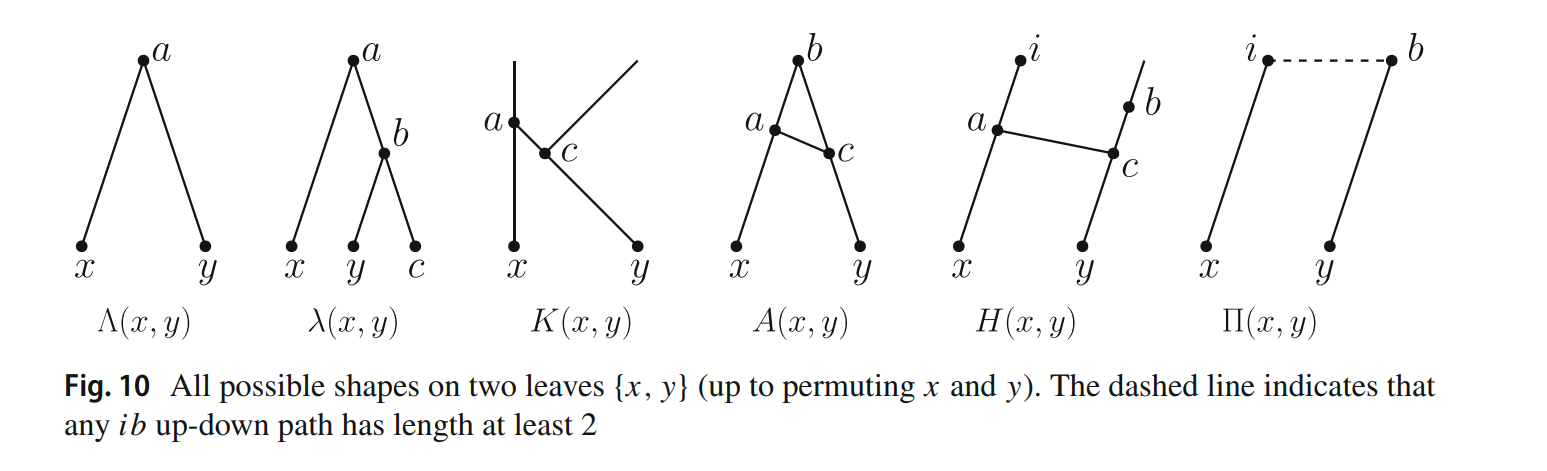

In [ ]:
"""
The function LambdaFU represents the function described in the article with the
  letter Λ. It returns true if the conditions are met or false otherwise.
Output: Boolean
"""
def LambdaFU(network, leaf1, leaf2):
  if network[leaf1] == network[leaf2]:
    return True
  return False


"""
The function LambdaFL represents the function described in the article with the
  letter λ. It returns true if the conditions are met or false otherwise.
Output: Boolean
"""
def LambdaFL(network, leaf1, leaf2):
  check = 0
  count = False
  a = GetValue(network[leaf1])
  for b in network[leaf2]:
    for n in network[b]:
      if n == a:
        check = True
      if type(n) == str:
        count += 1
  if count == 2 and check:
    return True
  return False


"""
The function H represents the function described in the article with the letter
  H. It returns true if the conditions are met or false otherwise.
Output: Boolean
"""
def H(network, leaf1, leaf2): 
  a = GetValue(network[leaf1])
  c = GetValue(network[leaf2])
  #Reticulated
  if c in GetReticulatedNodes(network):
    #Parents Connected
    if a in GetParents(network, c):
      return True
  return False


"""
The function A represents the function described in the article with the letter
  A. It returns true if the conditions are met or false otherwise.
Output: Boolean
Actually not used in main algorithm
"""
# def A(network, leaf1, leaf2):
#   listAux = []
#   for n in network[leaf1]:
#     for n1 in network[n]:
#       if type(n1) != str:
#         listAux.append(n1)
#     if len(listAux) != 2:
#       return False
#   for n in network[leaf2]:
#     for n1 in network[n]:
#       if (n in (listAux[0], listAux[1])) and n1 in ((listAux[0], listAux[1])):
#         return True
#   return False


"""
The function Pi represents the function described in the article with the letter
  Π. It returns true if the conditions are met or false otherwise.
Output: Boolean
"""
def Pi(network, leaf1, leaf2):
  if nx.shortest_path_length(network, source=leaf1, target=leaf2) >= 4:
    return True
  else:
    return False

**Medium-Level Functions**

In this cell are declared all those functions that have specific objectives but need further development or require other functions in order to work.

In [ ]:
"""
The BiconnectedNodes function returns all biconnected nodes, i.e. removing
  them does not affect the overall network connection.
Output: List of biconnected nodes
"""
def BiconnectedNodes(network):
  list_BN = []
  for node in network.nodes:
    #Connected_nodes
    biconnected = True
    for n in network[node]:
      g_copy = nx.Graph(network)
      if type(n) == int:
        if n < node:
          if not IsBiconnected(g_copy, node, n):
            biconnected = False
            break
    if biconnected:
      list_BN.append(node)
  return list_BN


"""
The IsBiconnected function returns true or false depending on whether removing a
  particular edge the network is still connected.
Output: Boolean
"""
def IsBiconnected(network, n1, n2):
  network.remove_edge(n1, n2)
  return nx.is_connected(network)


"""
The VisitedLeaves function returns the set of leaves that can be visited from a
  set of nodes passed by parameter.
Output: List of visited leaves
"""
def VisitedLeaves(network, nodes):
  list_visited_leaves = []
  for node in nodes:
    for n in network[node]:
      if type(n) == str:
        list_visited_leaves.append(n)
      else:
        if n > node and n not in nodes:
          #Recursive
          prov = VisitedLeaves(network, [n])
          for p in prov:
            if p not in list_visited_leaves:
              list_visited_leaves.append(p)
  return list_visited_leaves


"""
The GetLeaves function returns all the leaves of a network that are not in the
  set of leaves passed by parameter and can be visited.
Output: List of leaves
"""
def GetLeaves(network, selectedLeaves):
  result = []
  for leaf in VisitedLeaves(network, [0]):
    if leaf not in selectedLeaves:
      result.append(leaf)
  return result


"""
The GetMax function returns the largest foundation node.
Output: Integer with position of largest FN
"""
def GetMax(listFN):
  aux = 0
  for fn in listFN:
    if len(fn) > aux:
      aux = len(fn)
  return aux


"""
The GetSubNetworksWithTopNodes function calculates all subnets that are in a 
  network. are found in a network. Each of these subnetworks is obtained from the
  nodes that are not in the list of bi-connected nodes in the network. In 
  addition, the top nodes of each of these are stored.
Output: List of subnetworks, list of their topnodes
"""
def GetSubNetworksWithTopNodes(network, nodes):
  nodes_b = BiconnectedNodes(GraphWithoutLeaves(network))
  nodes_not_in = []
  topNodes = []
  for n in nodes:
    if n not in nodes_b:
      nodes_not_in.append(n)
  list_sub_network = []
  #Out JOIN
  for n in nodes_not_in:
    list_sub_network.append(VisitedLeaves(network, [n]))
    topNodes.append(GetTopNode([n]))
  return list_sub_network, topNodes


"""
In the FindBlobTreeWithTopNodes function, from the subnetworks obtained, all the
  necessary nodes are collected to form the list of nodes that form the blob tree.
  For all those blob trees, the topnodes of these are collected.
Output: List of blob trees and list of their topnodes
"""
def FindBlobTreeWithTopNodes(networks):
  listSubNet = []
  listTopNodes = []
  for network in networks:
    nodes = GetNodes(network)
    sn, topNodes = GetSubNetworksWithTopNodes(network, nodes)
    listSubNet.append(sn)
    listTopNodes.append(topNodes)
  return listSubNet, listTopNodes


"""
The GetSubNetworks function calculates all subnets that are in a network. are 
  found in a network. Each of these subnetworks is obtained from the nodes that
  are not in the list of bi-connected nodes in the network.
Output: List of subnetworks
"""
def GetSubNetworks(network, nodes):
  nodes_b = BiconnectedNodes(GraphWithoutLeaves(network))
  nodes_not_in = []
  for n in nodes:
    if n not in nodes_b:
      nodes_not_in.append(n)
  list_sub_network = []
  #Out JOIN
  for n in nodes_not_in:
    list_sub_network.append(VisitedLeaves(network, [n]))
  return list_sub_network


"""
In the FindBlobTree function, from the subnetworks obtained, all the
  necessary nodes are collected to form the list of nodes that form the blob tree.
Output: List of blob trees
"""
def FindBlobTree(networks):
  listSubNet = []
  for network in networks:
    nodes = GetNodes(network)
    listSubNet.append(GetSubNetworks(network, nodes))
  return listSubNet


"""
In the GetNA function, a subnetwork is obtained from a node. This node is called
  node A, from which the subnetwork NA is obtained.
Output: Subnetwork NA
"""
def GetNA(network, nodeA):
  nodes = [nodeA]
  GetNANodes(network, nodeA, nodes)
  NA = network.subgraph(nodes)
  return NA


"""
The GetNANodes function returns all the nodes that will be part of the NA subnetwork.
Output: List of nodes of NA
"""
def GetNANodes(network, nodeA, nodes):
  for node in network[nodeA]:
    if type(node) == str and node not in nodes:
      nodes.append(node)
      GetNANodes(network, node, nodes)
    if type(node) == int and type(nodeA) == int:
      if node > nodeA and node not in nodes:
        nodes.append(node)
        GetNANodes(network, node, nodes)


"""
In the GetP function, a subnetwork is obtained from a node. This node is called
  node P, from which the subnetwork NP is obtained. NP is formed from the nodes
  that are neither in NA nor at the intersection of the two sub-networks.
Output: Subnetwork NP
"""
def GetP(network, nodeA, topNodeA, NA):
  nodes = []
  GetPNodes(network, nodes, NA)
  NP = network.subgraph(nodes)
  NAprima = []
  GetNANodes(network, topNodeA, NAprima)
  NP = DeleteIntersectionNodes(NP, NAprima, NA)
  return NP


"""
The GetPNodes function returns all the nodes that will be part of the NP subnetwork.
Output: -
"""
def GetPNodes(network, nodesP, NA):
  for node in list(network.nodes()):
    if node not in list(NA.nodes()):
      nodesP.append(node)


"""
The DeleteIntersectionNodes function deletes nodes that are not in NA but are
  disconnected from the network.
Output: Network without the intersection nodes
"""
def DeleteIntersectionNodes(network, NAprima, NA):
  nodesA = []
  copiedGraph = nx.Graph(network)
  for node in list(NA.nodes()):
    nodesA.append(node)
  for node in NAprima:
    if node not in nodesA:
      copiedGraph.remove_node(node)
  return copiedGraph


"""
In the ReplacePureNode function, the new network is formed from the NA and NP
  subnetworks.
Output: Network composed by NA and NP
"""
def ReplacePureNode(network, topNodeA, p, NA):
  NP = GetP(network, p, topNodeA, NA) 
  H = nx.compose(NP, NA)
  H.add_edge(topNodeA, p)
  return H


"""
The FindFoundationNodes function returns those foundations nodes that are common
  in all the analysed networks.
Output: List of common SN (FN)
"""
def FindFoundationNodes(listSN):
  commonSN = []
  common = 1
  for sn in listSN[0]:
    i = 1
    while i < len(listSN):
      for sn1 in listSN[i]:
        if GetCommonFN(sn, sn1):
          common += 1
      if common <= i:
        i = len(listSN)
      else:
        i += 1
    if common == len(listSN):
      commonSN.append(sn)
    common = 1

  return commonSN


"""
The ReduceLeafFN function collapses the minimum foundation node found. This
  foundation node will in all cases contain a total of 2 leaves. As a result,
  these two leaves will become one and the same under the name {x,y}. The parent
  of these two will be replaced by this new collapsed node.
Output: List of networks with collapsed node and string with the name of this new
  node
"""
def ReduceLeafFN(fn, networks):
  listAuxGraphs = []
  formatedString = '{var1},{var2}'.format(var1 = fn[0], var2 = fn[1])
  formatedString = '{'+formatedString+'}'
  for graph in networks:
    # Both leaves have the same ascendant
    aux = GetValue(graph[formatedString[1]])
    mapping = {aux:formatedString}
    G = nx.relabel_nodes(graph, mapping)
    G.remove_nodes_from(fn)
    listAuxGraphs.append(G)
    nameNewNode = formatedString
  return listAuxGraphs,nameNewNode

**High-Level Functions**

At this level, functions are defined which implement the logic of the final algorithm, whereby their development resembles the final logic of the function.

In [ ]:
"""
The UnCollapse function uncollapses the node created with an r-node and the two
  collapsed leaves. The r node indicates the depth of the recursion in which it
  has been created.
Output: Uncollapsed Network
"""
def UnCollapse(network, namesNewNodes, depth):
  for n, nameNewNode in enumerate(namesNewNodes):
    #Revisar si hay tiempo REGEXP
    firstNode = nameNewNode[1]
    secondNode = nameNewNode[3]
    recoveredName = 'r{depth}{n}'.format(depth = depth, n = n)

    mapping = {nameNewNode:recoveredName}
    G = nx.relabel_nodes(network, mapping)
    G.add_edge(recoveredName, firstNode)
    G.add_edge(recoveredName, secondNode)
  return G


"""
The UnCollapseNA function uncollapses the node created with the foundation node
  of A to return the NA subnetwork instead.
Output: Uncollapsed Network with NA
"""
def UnCollapseNA(graph, topNodeA, nameNodeA, NA):
  p = GetValue(graph[nameNodeA])
  G = nx.Graph(graph)
  G.remove_node(nameNodeA)
  graphResultant = nx.compose(G, NA)
  graphResultant.add_edge(p, topNodeA)
  return graphResultant

In [ ]:
"""
The AddNodeAC function adds two new nodes a and c in the network. These nodes
  have marked in their names the level of depth at which they have been created.
  In addition, a new edge is created between these two created nodes.
Output: -
"""
def AddNodeAC(network, leaf1, leaf2, depth):
  a = 'a{depth}'.format(depth = depth)
  c = 'c{depth}'.format(depth = depth)
  parentLeaf1 = GetValue(network[leaf1])
  parentLeaf2 = GetValue(network[leaf2])
  network.remove_edge(leaf1, parentLeaf1)
  network.remove_edge(leaf2, parentLeaf2)
  network.add_edge(leaf1, a)
  network.add_edge(leaf2, c)
  network.add_edge(a, parentLeaf1)
  network.add_edge(c, parentLeaf2)
  network.add_edge(a, c)


"""
The CheckOneEach function checks that for the different types of inter-leaf
  connections required, there are a Λ(x,y), an H(x,y) and a λ(x,y) or λ(y,x) or
  Π(x,y). Store the index of the last check.
Output: List of checks and index of third one
"""
def CheckOneEach(graphs, leaf1, leaf2):
  check = [False, False, False]
  index = -1
  for n, graph in enumerate(graphs):
    if LambdaFU(graph, leaf1, leaf2) and not check[0]:
      check[0] = True
    if H(graph, leaf1, leaf2) and not check[1]:
      check[1] = True
    if (LambdaFL(graph, leaf1, leaf2) or Pi(graph, leaf1, leaf2)) and not check[2]:
      check[2] = True
      index = n
  return check[0] and check[1] and check[2], index

"""
The CollapsingMaximalCP function is composed of different parts. First, it checks
  all the blobs trees in the network. Secondly, it looks for the foundation nodes 
  of these networks. Finally, for the smallest foundation node found, it collapses
  it by creating a new node.
Output: Collapsed Networks and name of new node (if created)
"""
def CollapsingMaximalCP(T):
  BT = FindBlobTree(T)
  foundationNodes = FindFoundationNodes(BT)
  listNamesNewNodes = []
  reconstructed = False
  for cp in foundationNodes:
    if len(cp) == 2:
      if LambdaFU(T[0], cp[0], cp[1]):
        print("Maximal CP to collapse: ", cp)
        t, nameNewNode = ReduceLeafFN(cp, T)
        print("Node Created: ", nameNewNode)
        listNamesNewNodes.append(nameNewNode)
        reconstructed = True
  if reconstructed:
    return t, listNamesNewNodes
  return T, listNamesNewNodes


"""
The FindMinimalFoundationNodes function searches for the minimum set of foundation
  nodes available.
Output: Minimal Foundation Nodes
"""
def FindMinimalFoundationNodes(foundationNodes):
  minimal = MAX_NODE_RANGE
  fnMinimal = []

  for fn in foundationNodes:
    if len(fn) < minimal:
      minimal = len(fn)
      fnMinimal = fn
  return fnMinimal


"""
The FindMinimalFoundationNodesWithTopNode function searches for the minimum set
  of foundation nodes available. In addition, it saves the top node of the chosen
  foundation node.
Output: Minimal Foundation Nodes and its top node
"""
def FindMinimalFoundationNodesWithTopNode(BT, topNodes):
  foundationNodes = FindFoundationNodes(BT)
  minimal = MAX_NODE_RANGE
  fnMinimal = []

  for fn in foundationNodes:
    if len(fn) < minimal:
      minimal = len(fn)
      fnMinimal = fn

  #Find Top Nodes for each BT
  topNodesFN = []
  for n1, bt1 in enumerate(BT):
    for n2, bt2 in enumerate(bt1):
      if GetCommonFN(bt2, fnMinimal):
        topNodesFN.append(topNodes[n1][n2])

  return fnMinimal, topNodesFN


"""
The Check3Types function checks for the three types of inter-leaves connections
  required. These checks are carried out for all possible combinations between 
  the leaves. The order of the combination is decisive, as it is not the same to
  combine x,y as y,x.
Output: Name of leaves(leaf1 and leaf2), index of third type
"""
def Check3Types(t, A):
  for leaf1 in A:
    for leaf2 in A:
      if leaf1 != leaf2:
        check, i = CheckOneEach(t, leaf1, leaf2)
        if check:
          return leaf1, leaf2, i
  return -1, -1, -1


"""
The CollapseNA function collapses the NA subnetwork within the network into a
  single node.
Output: NP network with node A
"""
def CollapseNA(graph, p, nodeTopA, NA, A):
  NP = nx.Graph(GetP(graph, p, nodeTopA, NA))
  nodeA = GetNodeA(A)
  NP.add_edge(p, nodeA)
  return NP


"""
The GetNodeA function is an auxiliary function to generate the name of the new
  node A from the foundation node A.
Output: Name of new node A
"""
def GetNodeA(A):
  string_ints = [str(int) for int in A]
  return ' '.join(string_ints)


"""
The ThereAreIsomorphic function indicates whether two nets are isomorphic. If so,
  it deletes the second of these two. This check is done for all nets passed, but
  the function terminates when any or none of the nets are deleted.
Output: Boolean
"""
def ThereAreIsomorphic(tprima):
  if len(tprima) > 1:
    indexes = range(0, len(tprima))
    for pair in itertools.combinations(indexes, 2):
      if nx.is_isomorphic(tprima[pair[0]], tprima[pair[1]]):
        print("Nmlls {n1} is isomorphic with {n2}".format(n1 = pair[0], n2 = pair[1]))
        tprima.remove(tprima[pair[0]])
        print("Size of tprima: {tprima}".format(tprima = len(tprima)))
        return True

  return False

#**3. MAIN ALGORITHM**

**Pseudocode**
(P. 34)

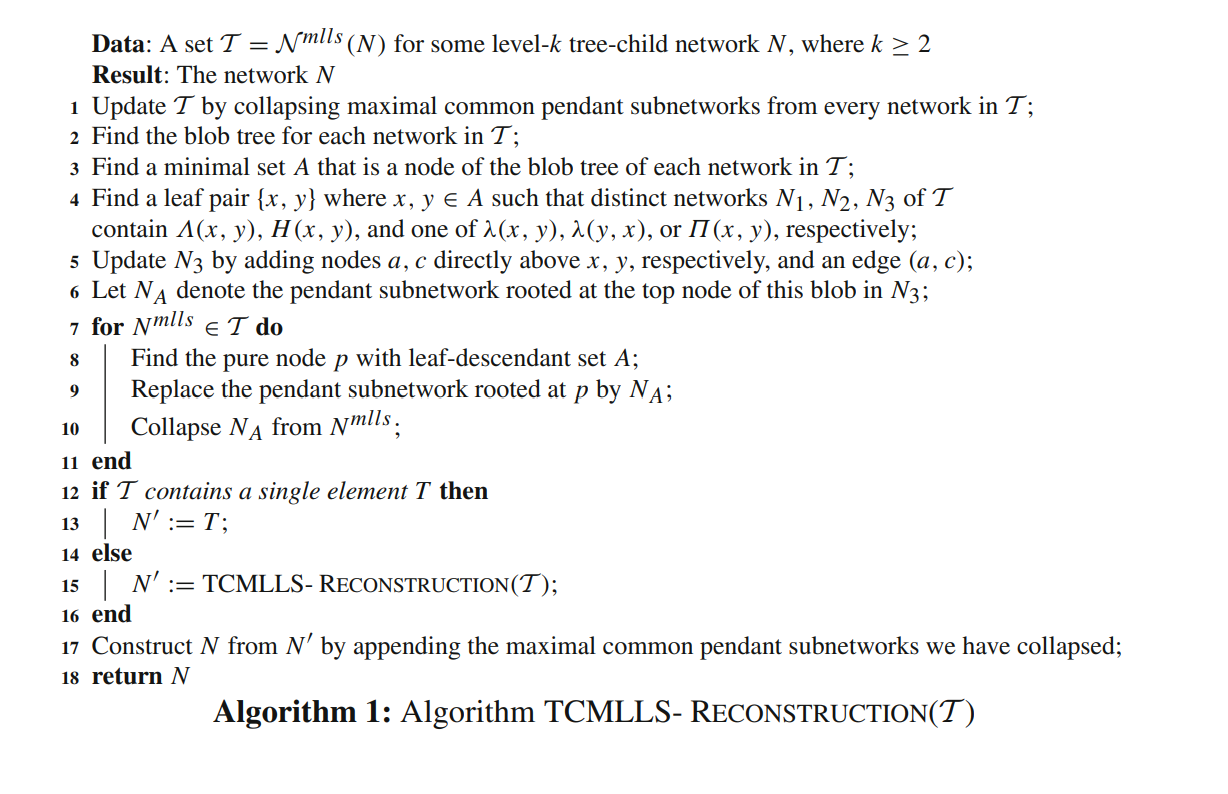

**Visual Example of how it works**
(Figura 16 p. 35)

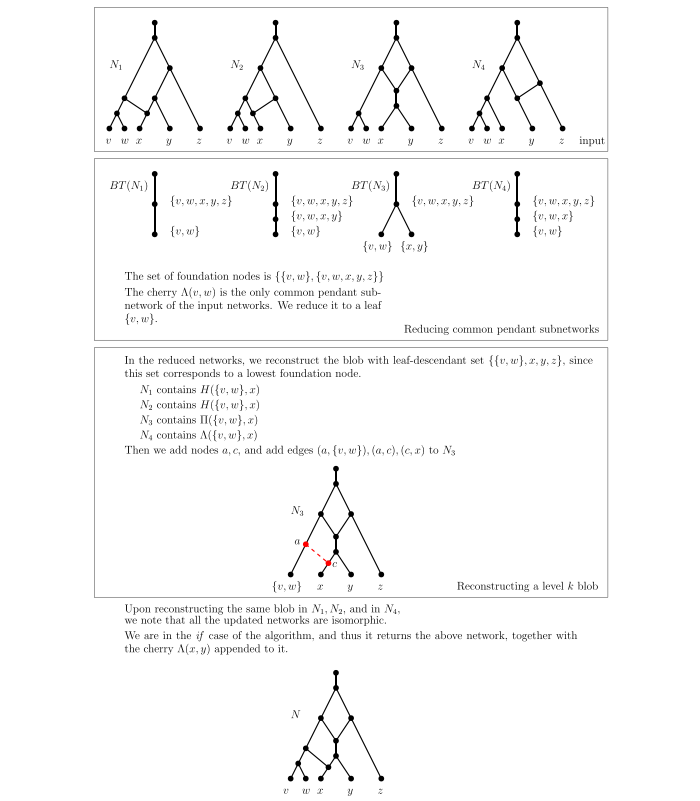

**Main Algorithm**

In [ ]:
def TCMLLS_RECONSTRUCTION(T, depth = 0):

  print()
  print("RECURSION WITH DEPTH ", depth)
  print()

  #0
  if len(T) == 0:
    return T

  #0.5
  if len(T) == 1:
    return T

  #1
  print("Starting Collapsing Part")
  t, namesNewNodes = CollapsingMaximalCP(T)
  print("Ended Collapsing Part\n")
  #2 - topNodes is optimization
  BT, topNodes = FindBlobTreeWithTopNodes(t)
  print("BT: ",BT)
  print("Top nodes: ", topNodes)
  #3
  A, topNodeA = FindMinimalFoundationNodesWithTopNode(BT, topNodes)
  print("Minimal Foundation Nodes Set as A: ", A)
  print("Top Node of set A: ",topNodeA)
  #4
  leaf1, leaf2, N3 = Check3Types(t, A)
  print("Pair of leaves: ", leaf1, leaf2)
  print("Index of N3: ", N3)
  #5
  tprima = []
  if N3 != -1 and leaf1 != -1 and leaf2 != -1:
    AddNodeAC(t[N3], leaf1, leaf2, depth)
    print("Added a - c nodes in depth ", depth)
  #6
  NA = GetNA(t[N3], topNodeA[N3])
  for n, nmlls in enumerate(t):
    #8
    p = GetPureNode(nmlls, topNodeA[n])
    print("Node p: ", p)
    #9
    t[n] = ReplacePureNode(nmlls, topNodeA[n], p, NA)
    #10
    tprima.append(CollapseNA(t[n], p, topNodeA[n], NA, A))

  #11
  # Isomorphic reduction
  areIsomorphics = True
  while areIsomorphics:
    areIsomorphics = ThereAreIsomorphic(tprima)

  #12
  if len(tprima) == 1:
    Nprima = t[0]
  #14
  else:
    Nprima = TCMLLS_RECONSTRUCTION(tprima, depth + 1)
    #15
    Nprima = UnCollapseNA(Nprima, topNodeA[N3], GetNodeA(A), NA)

  #17
  if len(namesNewNodes) == 0:
    return Nprima
  #18
  return UnCollapse(Nprima, namesNewNodes, depth)

#**4. MLLS EXTRACTION FROM ORIGINAL NETWORK**

In [ ]:
"""
The GetReticulatedNodes function returns the reticulated nodes from a graph. 
  Reticulated nodes are those nodes that have an input degree greater than or 
  equal to 2
Output: List of nodes
"""
def GetReticulatedNodes(graph):
  reticulatedNodes = []
  for node in GetNodes(graph):
    counter = 0
    for c in graph[node]:
      if type(c) == int:
        if c < node:
          counter += 1
    if counter >= 2:
      reticulatedNodes.append(node)
    
  return reticulatedNodes


"""
The GetNumberOfDeletedNodes function returns the number of degree 2 nodes to be 
  deleted in a graph.
Output: Integer
"""
def GetNumberOfDeletedNodes(graph):
  deletedNodes = []
  for node in graph.nodes:
    if graph.degree(node) == 2:
      deletedNodes.append(node)
  return deletedNodes


"""
The DeleteDegree2Nodes function deletes degree 2 nodes in a graph. It returns
  the complete graph without the nodes that do not provide information.
Output: Resultant Graph
"""
def DeleteDegree2Nodes(graph, deleteNodes):
  resultantGraph = nx.Graph(graph)
  for nodeToDelete in deleteNodes:
    connection = []
    for node in graph[nodeToDelete]:
      connection.append(node)
    resultantGraph.remove_node(nodeToDelete)
    resultantGraph.add_edge(connection[0], connection[1])
  return resultantGraph


"""
The CreateMLLSNetworks function extracts MLLS (maximum lower-level subnetwork) 
  from an original graph. For an MLLS to be valid, the resulting network must 
  have exactly 3 edges and 2 fewer nodes.
Output: List of maximum lower-level subnetworks
"""
def CreateMLLSNetworks(originalNetwork, k):
  nmlls = []
  reticulatedNodesK = GetReticulatedNodesK(originalNetwork, k)
  for rn in reticulatedNodesK:
    #For each reticulated parent edge.
    for c in originalNetwork[rn]:
      if type(c) == int:
        if c < rn:
          copiedNetwork = nx.Graph(originalNetwork)
          copiedNetwork.remove_edge(rn, c)
          deleteNodes = GetNumberOfDeletedNodes(copiedNetwork)
          copiedNetwork = DeleteDegree2Nodes(copiedNetwork, deleteNodes)
          while len(deleteNodes) > 0:
            deleteNodes = GetNumberOfDeletedNodes(copiedNetwork)
            copiedNetwork = DeleteDegree2Nodes(copiedNetwork, deleteNodes)         
          #The number of edges removed is equal to three and the number of nodes
          # is equal to two
          if (copiedNetwork.number_of_edges() == originalNetwork.number_of_edges() - 3
          and copiedNetwork.number_of_nodes() == originalNetwork.number_of_nodes() - 2):
            nmlls.append(copiedNetwork)
  return nmlls

In [ ]:
"""
The GetReticulatedNodesK function returns all reticulated nodes which are in 
  biconnected components with level-k. That means that in this biconnected 
  component it must have at most k reticulated nodes.
Output: List of reticulated nodes in level-k networks
"""
def GetReticulatedNodesK(network, k):
  rn = GetReticulatedNodes(network)
  bicomponents = list(nx.biconnected_components(GraphWithoutLeaves(network)))
  rnFinal = []
  for bc in bicomponents:
    kbc, rnIn = GetLevelK(bc, rn)
    if kbc <= k:
      rnFinal.extend(rnIn)

  return rnFinal

"""
The GetLevelK function returns the k level of a network and its reticulated nodes
Output: Integer and list of reticulated nodes
"""
def GetLevelK(bicomponent, rn):
  k = 0
  rnIn = []
  for i in rn:
    if i in bicomponent:
      k += 1
      rnIn.append(i)

  return k, rnIn

#**5. FIRST EXAMPLE**

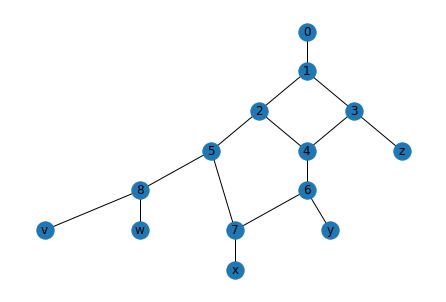

In [ ]:
#Original Network
OriginalGraph = nx.Graph()
OriginalGraph.add_edge(0, 1)
OriginalGraph.add_edge(1, 2)
OriginalGraph.add_edge(1, 3)
OriginalGraph.add_edge(2, 4)
OriginalGraph.add_edge(3, 4)
OriginalGraph.add_edge(3, 'z')
OriginalGraph.add_edge(2, 5)
OriginalGraph.add_edge(4, 6)
OriginalGraph.add_edge(5, 7)
OriginalGraph.add_edge(6, 7)
OriginalGraph.add_edge(5, 8)
OriginalGraph.add_edge(6, 'y')
OriginalGraph.add_edge(8, 'v')
OriginalGraph.add_edge(8, 'w')
OriginalGraph.add_edge(7, 'x')

pos = graphviz_layout(OriginalGraph, prog="dot")
nx.draw(OriginalGraph, pos, with_labels = True)
plt.show()

In [ ]:
#Generation of the maximum lower-level subnetwork
T = CreateMLLSNetworks(OriginalGraph, k = 2)
print("Generated {number} nmlls graphs from original graph".format(number = len(T)))

Generated 4 nmlls graphs from original graph


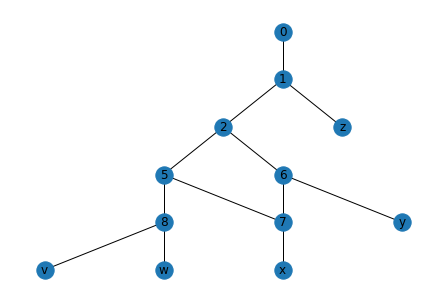

In [ ]:
#Visualization example
index = 1
pos = graphviz_layout(T[index], prog="dot")
nx.draw(T[index], pos, with_labels = True)
plt.show()

In [ ]:
#Reconstruction of original network using the nmlls set
ReconstructedN = TCMLLS_RECONSTRUCTION(T)


RECURSION WITH DEPTH  0

Starting Collapsing Part
Maximal CP to collapse:  ['v', 'w']
Node Created:  {v,w}
Ended Collapsing Part

BT:  [[['z', 'x', 'y', '{v,w}']], [['x', '{v,w}', 'y', 'z'], ['x', '{v,w}', 'y']], [['y', 'x', '{v,w}', 'z'], ['y', 'x']], [['y', '{v,w}', 'x', 'z'], ['{v,w}', 'x']]]
Top nodes:  [[1], [1, 2], [1, 6], [1, 5]]
Minimal Foundation Nodes Set as A:  ['z', 'x', 'y', '{v,w}']
Top Node of set A:  [1, 1, 1, 1]
Pair of leaves:  y x
Index of N3:  3
Added a - c nodes in depth  0
Node p:  0
Node p:  0
Node p:  0
Node p:  0
Nmlls 0 is isomorphic with 1
Size of tprima: 3
Nmlls 0 is isomorphic with 1
Size of tprima: 2
Nmlls 0 is isomorphic with 1
Size of tprima: 1


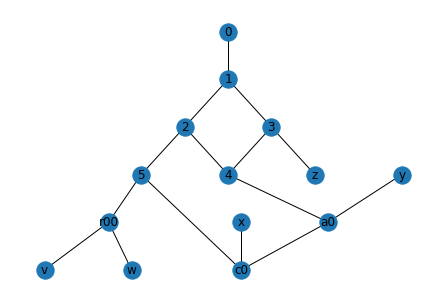

In [ ]:
#Reconstructed network
pos = graphviz_layout(ReconstructedN, prog="dot")
nx.draw(ReconstructedN, pos, with_labels = True)
plt.show()

#**6. SECOND EXAMPLE**

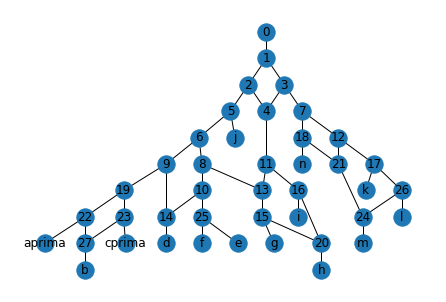

In [ ]:
#Original Network
OriginalGraph2 = nx.Graph()
OriginalGraph2.add_edge(0, 1)
OriginalGraph2.add_edge(1, 2)
OriginalGraph2.add_edge(1, 3)
OriginalGraph2.add_edge(2, 4)
OriginalGraph2.add_edge(3, 4)
OriginalGraph2.add_edge(2, 5)
OriginalGraph2.add_edge(5, 6)
OriginalGraph2.add_edge(5, 'j')
OriginalGraph2.add_edge(3, 7)
OriginalGraph2.add_edge(4, 11)
OriginalGraph2.add_edge(6, 8)
OriginalGraph2.add_edge(6, 9)

OriginalGraph2.add_edge(7, 12)
OriginalGraph2.add_edge(7, 18)
OriginalGraph2.add_edge(8, 13)
OriginalGraph2.add_edge(8, 10)
OriginalGraph2.add_edge(9, 19)
OriginalGraph2.add_edge(9, 14)
OriginalGraph2.add_edge(10, 14)
OriginalGraph2.add_edge(10, 25)
OriginalGraph2.add_edge(11, 13)
OriginalGraph2.add_edge(11, 16)
OriginalGraph2.add_edge(12, 17)

OriginalGraph2.add_edge(12, 21)
OriginalGraph2.add_edge(13, 15)
OriginalGraph2.add_edge(14, 'd')
OriginalGraph2.add_edge(15, 'g')
OriginalGraph2.add_edge(15, 20)
OriginalGraph2.add_edge(16, 'i')
OriginalGraph2.add_edge(16, 20)
OriginalGraph2.add_edge(17, 'k')
OriginalGraph2.add_edge(17, 26)
OriginalGraph2.add_edge(18, 21)
OriginalGraph2.add_edge(18, 'n')
OriginalGraph2.add_edge(19, 22)
OriginalGraph2.add_edge(19, 23)

OriginalGraph2.add_edge(20, 'h')
OriginalGraph2.add_edge(21, 24)
OriginalGraph2.add_edge(22, 'aprima')
OriginalGraph2.add_edge(22, 27)
OriginalGraph2.add_edge(23, 'cprima')
OriginalGraph2.add_edge(23, 27)
OriginalGraph2.add_edge(24, 26)
OriginalGraph2.add_edge(24, 'm')
OriginalGraph2.add_edge(25, 'e')
OriginalGraph2.add_edge(25, 'f')
OriginalGraph2.add_edge(26, 'l')
OriginalGraph2.add_edge(27, 'b')

pos = graphviz_layout(OriginalGraph2, prog="dot")
nx.draw(OriginalGraph2, pos, with_labels = True)
plt.show()

In [ ]:
#Generation of the maximum lower-level subnetwork
T2 = CreateMLLSNetworks(OriginalGraph2, k = 4)
print("Generated {number} nmlls graphs from original graph".format(number = len(T2)))

Generated 14 nmlls graphs from original graph


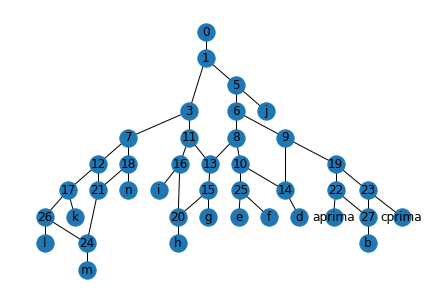

In [ ]:
#Visualization example
index = 0
pos = graphviz_layout(T2[index], prog="dot")
nx.draw(T2[index], pos, with_labels = True)
plt.show()

In [ ]:
#Reconstruction of original network using the nmlls set
ReconstructedN2 = TCMLLS_RECONSTRUCTION(T2)


RECURSION WITH DEPTH  0

Starting Collapsing Part
Maximal CP to collapse:  ['e', 'f']
Node Created:  {e,f}
Ended Collapsing Part

BT:  [[['k', 'l', 'm', 'n', 'g', 'h', 'i', 'd', '{e,f}', 'aprima', 'b', 'cprima', 'j'], ['k', 'l', 'm', 'n'], ['aprima', 'b', 'cprima']], [['g', 'h', 'd', '{e,f}', 'aprima', 'b', 'cprima', 'j', 'i', 'k', 'l', 'm', 'n'], ['g', 'h', 'd', '{e,f}', 'aprima', 'b', 'cprima', 'j', 'i'], ['k', 'l', 'm', 'n'], ['aprima', 'b', 'cprima']], [['i', 'h', 'g', 'aprima', 'b', 'cprima', 'd', '{e,f}', 'j', 'k', 'l', 'm', 'n'], ['aprima', 'b', 'cprima', 'd', '{e,f}', 'j'], ['aprima', 'b', 'cprima', 'd', '{e,f}'], ['k', 'l', 'm', 'n'], ['i', 'h', 'g'], ['aprima', 'b', 'cprima']], [['i', 'h', 'd', '{e,f}', 'g', 'aprima', 'b', 'cprima', 'j', 'k', 'l', 'm', 'n'], ['k', 'l', 'm', 'n'], ['aprima', 'b', 'cprima']], [['g', 'h', 'i', '{e,f}', 'd', 'aprima', 'b', 'cprima', 'j', 'k', 'l', 'm', 'n'], ['k', 'l', 'm', 'n'], ['{e,f}', 'd'], ['aprima', 'b', 'cprima']], [['g', 'h', 'i', '{e,f

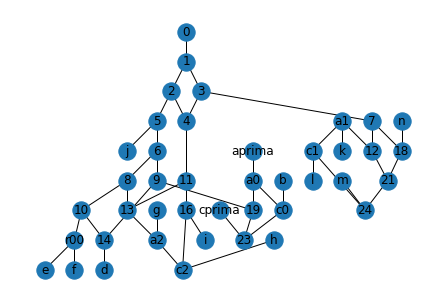

In [ ]:
pos = graphviz_layout(ReconstructedN2, prog="dot")
nx.draw(ReconstructedN2, pos, with_labels = True)
plt.show()

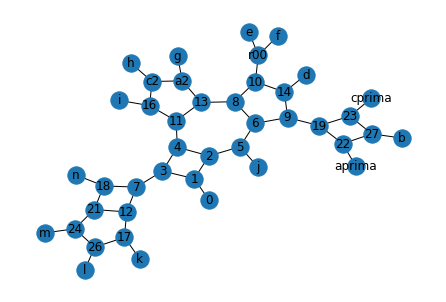

In [ ]:
nx.draw_kamada_kawai(ReconstructedN2, with_labels = True)

In [ ]:
#Equivalences
mapping = {
    'a0': 22,
    'c0': 27,
    'a1': 17,
    'c1': 26,
    'a2': 15,
    'c2': 20
}
#ReconstructedN2 = nx.relabel_nodes(ReconstructedN2, mapping)

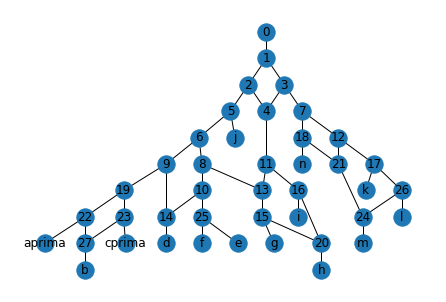

In [ ]:
pos = graphviz_layout(OriginalGraph2, prog="dot")
nx.draw(OriginalGraph2, pos, with_labels = True)
plt.show()